In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

In [3]:
import os
import numpy as np
import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage

import matplotlib.pyplot as plt
%matplotlib inline
import pyfits as pf

import functions as fn
fn = reload(fn)

In [6]:
data_path = '/nfs/lsst2/photocalData/data/observer2/'
NB_568 = [496511,496512,496513,496514]
NB_671_1 = [496520,496521,496522]
NB_671_2  = [496524,496525,496526,496527,496528,496529]
NB_680 = [496533,496534,496535]
NB_700 = [496540,496541,496542]
BB = [496508, 496509, 496510]

NB_568_visits = [data_path + 'DECam_00' + str(_) + '.fits.fz' for _ in NB_568]
NB_671_visits_1 = [data_path + 'DECam_00' + str(_) + '.fits.fz' for _ in NB_671_1]
NB_671_visits_2 = [data_path + 'DECam_00' + str(_) + '.fits.fz' for _ in NB_671_2]
NB_680_visits = [data_path + 'DECam_00' + str(_) + '.fits.fz' for _ in NB_680]
NB_700_visits = [data_path + 'DECam_00' + str(_) + '.fits.fz' for _ in NB_700]
BB_visits = [data_path + 'DECam_00' + str(_) + '.fits.fz' for _ in NB_700]

HDU_NUM = 28

In [10]:
# testfile = NB_568_visits[1]
testfile = '/nfs/lsst2/photocalData/data/observer2/DECam_00496510.fits.fz'

Subtracting overscan of 2330.0
Removing hottest 4 pixels from
[280], [327]
[284], [328]
[281], [325]
[282], [329]
[282], [328]
Found local backgrounds of 135.4, 138.0, 135.5, 138.3
Subtracted their average = 136.8
Clipped mean, stddev of postage stamp = 2.26,  6


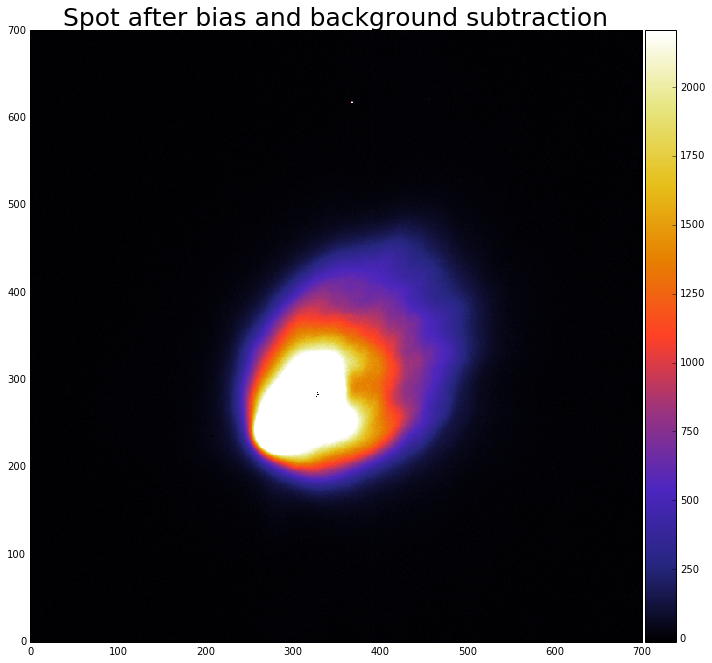

In [11]:
d_file = pf.open(testfile)
primaryHeader = d_file[0].header
exptime = primaryHeader['EXPTIME']
data = d_file[HDU_NUM].data

data = data.astype(np.float32) #convert data type
overscan_region = data[2073 + 100:4146-50,2160-40:2160-10]
overscan = np.mean(overscan_region)
print 'Subtracting overscan of', overscan
data -= float(overscan)

# approximate definition of upper half of one amplifier, just for ease of viewing/cropping
row_first = 4146/2
row_last = 4146
col_first = 2160/2
col_last = 2160
roi = data[row_first:row_last,col_first:col_last]
spot = roi[200:900,200:900]

n_bad_pix = 4
print 'Removing hottest %s pixels from'%n_bad_pix
for i in range(n_bad_pix +1): #remove the n hottest pixels
    bad_x, bad_y = np.where(spot == np.max(spot))
    print '%s, %s'%(bad_x, bad_y)
    spot[bad_x,bad_y] =0

local_background_1, clipped_sigma_1 = fn.getClippedMeanandStddev(spot[0:100,0:100])
local_background_2, clipped_sigma_2 = fn.getClippedMeanandStddev(spot[0:100,600:700])
local_background_3, clipped_sigma_3 = fn.getClippedMeanandStddev(spot[600:700,0:100])
local_background_4, clipped_sigma_4 = fn.getClippedMeanandStddev(spot[600:700,600:700])
mean_background = np.mean([local_background_1,local_background_2,local_background_3,local_background_4])
spot -= mean_background
print 'Found local backgrounds of %.1f, %.1f, %.1f, %.1f' %(local_background_1,local_background_2,local_background_3,local_background_4)
print 'Subtracted their average = %.1f'%mean_background


spot_clipped_mean, spot_std_dev = fn.getClippedMeanandStddev(spot, nsig=2)
print 'Clipped mean, stddev of postage stamp = %.2f, %2.f'%(spot_clipped_mean, spot_std_dev)

fn.ShowSpot(spot, half_stretch='auto', useClippedMean=True, n_sig_clip=2, title='Spot after bias and background subtraction')

WARNING, using fixed thr of 125 for low
Low threshold      = 125.00	 ADU
Flux               = 104.58	 mega-ADU
Brightness         = 10458.14	 kADU/s
Avg pix brightness = 152.87	 ADU/pix/s
(n pix used        = 68413)
WARNING, using fixed thr of 600 for high

High threshold     = 600.00	 ADU
Flux               = 94.84	 mega-ADU
Brightness         = 9484.09	 kADU/s
Avg pix brightness = 249.26	 ADU/pix/s
(n pix used        = 38049)

Ultra-high threshold = 1941.04	 ADU
Flux                 = 66.09	 mega-ADU
--------------------------------------- Brightness is meaningless here now but "=" 6608.65 kADU/s
Avg pix brightness   = 578.34	 ADU/pix/s
(n pix used          = 11427)

If we'd had a decent PSF, the flux in the first plot would all have gone ~into these pixels, so the average pixel brightness would have been: 
Avg pix brightness   = 915.21	 ADU/pix/s


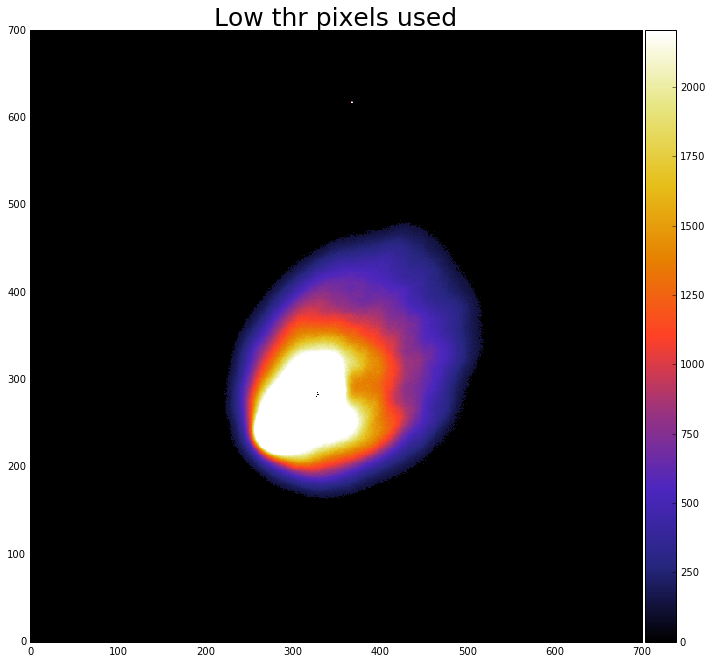

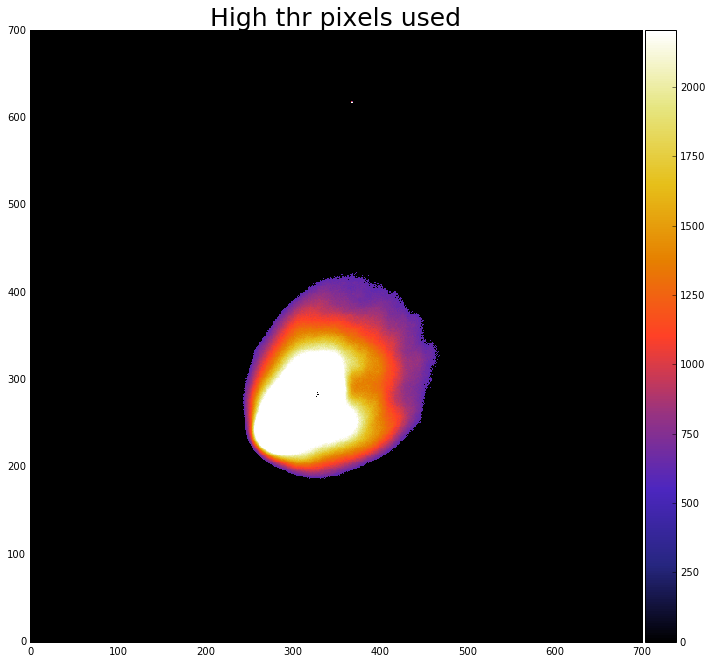

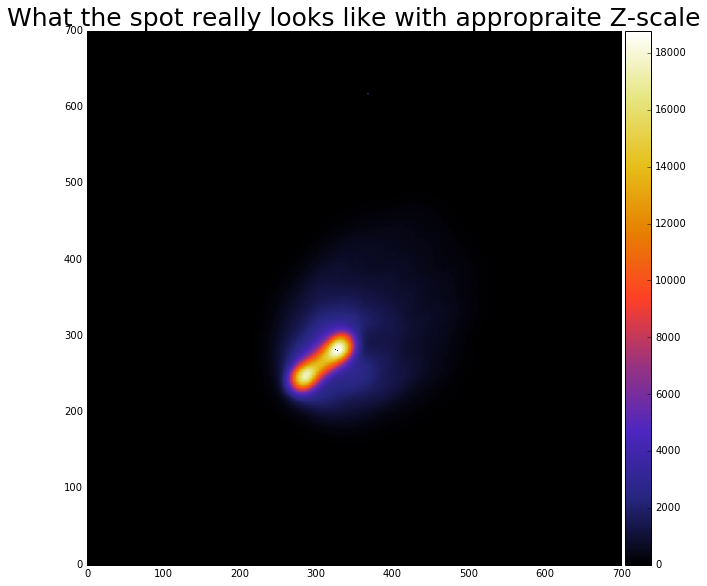

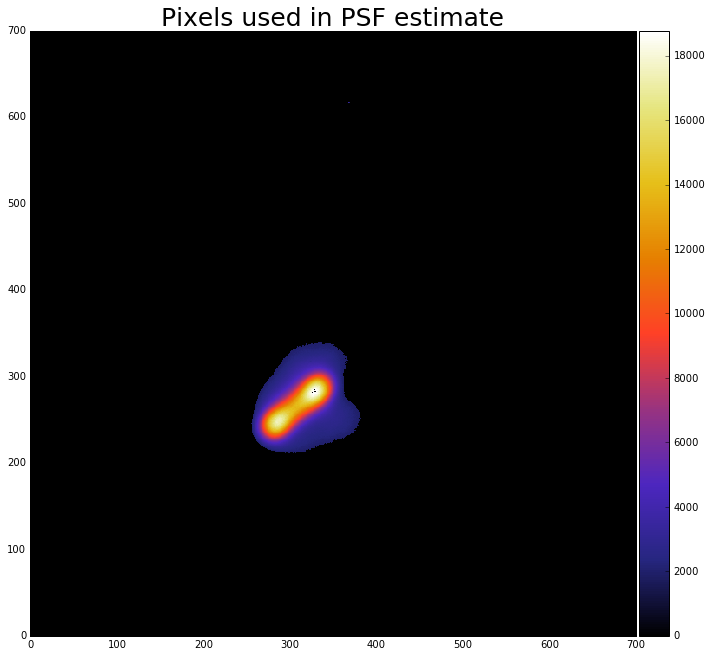

In [14]:
n_sig_above_background = 5
thr = spot_clipped_mean + (n_sig_above_background * spot_std_dev)
thr = 125
print 'WARNING, using fixed thr of %s for low'%thr
spot_thresholded = spot.copy()
thr_pix = np.where(spot_thresholded>thr) # for calculating flux per pixel
n_pix_above_thr = len(thr_pix[0]) # for calculating flux per pixel
spot_thresholded[spot_thresholded<=thr] = 0 #for the image
fn.ShowSpot(spot_thresholded, half_stretch='auto', useClippedMean=True, n_sig_clip=2, title='Low thr pixels used')

flux = spot_thresholded.sum()
print 'Low threshold      = %.2f\t ADU'%thr
print 'Flux               = %.2f\t mega-ADU' %(flux/1000000.)
print 'Brightness         = %.2f\t kADU/s'%(flux/float(exptime*1000))
print 'Avg pix brightness = %.2f\t ADU/pix/s'%(flux/float(exptime*n_pix_above_thr))
print '(n pix used        = %s)'%n_pix_above_thr

total_flux_save = flux

#----------------
# redo to look at the "core"
# if the focus was good, these would be the same
# but it wasn't.

n_sig_above_background = 25
thr = spot_clipped_mean + (n_sig_above_background * spot_std_dev)
thr = 600
print 'WARNING, using fixed thr of %s for high'%thr
spot_thresholded = spot.copy()
thr_pix = np.where(spot_thresholded>thr) # for calculating flux per pixel
n_pix_above_thr = len(thr_pix[0]) # for calculating flux per pixel
spot_thresholded[spot_thresholded<=thr] = 0 #for the image
fn.ShowSpot(spot_thresholded, half_stretch='auto', useClippedMean=True, n_sig_clip=2, title='High thr pixels used')

flux = spot_thresholded.sum()
print 
print 'High threshold     = %.2f\t ADU'%thr
print 'Flux               = %.2f\t mega-ADU' %(flux/1000000.)
print 'Brightness         = %.2f\t kADU/s'%(flux/float(exptime*1000))
print 'Avg pix brightness = %.2f\t ADU/pix/s'%(flux/float(exptime*n_pix_above_thr))
print '(n pix used        = %s)'%n_pix_above_thr

####################
# add these to show shape of bright spot, and estimate what things might have been like if we'd been difraction limited, or at least had a decent PSF:

spot_thresholded = spot.copy()
spot_thresholded[spot_thresholded<=0] = 0 #for the image
fn.ShowSpot(spot_thresholded, half_stretch=-1, useClippedMean=True, n_sig_clip=2, title='What the spot really looks like with appropraite Z-scale')


n_sig_above_background = 350
thr = spot_clipped_mean + (n_sig_above_background * spot_std_dev)
spot_thresholded = spot.copy()
thr_pix = np.where(spot_thresholded>thr) # for calculating flux per pixel
n_pix_above_thr = len(thr_pix[0]) # for calculating flux per pixel
spot_thresholded[spot_thresholded<=thr] = 0 #for the image
fn.ShowSpot(spot_thresholded, half_stretch=-1, useClippedMean=True, n_sig_clip=2, title='Pixels used in PSF estimate')

flux = spot_thresholded.sum()
print
print 'Ultra-high threshold = %.2f\t ADU'%thr
print 'Flux                 = %.2f\t mega-ADU' %(flux/1000000.)
print '--------------------------------------- Brightness is meaningless here now but "=" %.2f kADU/s'%(flux/float(exptime*1000))
print 'Avg pix brightness   = %.2f\t ADU/pix/s'%(flux/float(exptime*n_pix_above_thr))
print '(n pix used          = %s)'%n_pix_above_thr

print
print 'If we\'d had a decent PSF, the flux in the first plot would all have gone ~into these pixels, so the average pixel brightness would have been: '
print 'Avg pix brightness   = %.2f\t ADU/pix/s'%(total_flux_save/float(exptime*n_pix_above_thr))
